In [1]:
# ====================
# Full Benchmark Script
# ====================
# To be run in a Jupyter notebook (cells separated by comments)

# --- Cell 1: Imports & Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, tracemalloc

from objective_functions import compute_objective
from prox_operators   import prox_l1, prox_elastic_net

import iterative_solvers_pt2 as its  # alias più breve
from iterative_solvers_pt2 import (
    estimate_lipschitz,
    ista,
    fista,
    fista_delta,
    get_metrics
)

# Hook L-BFGS into same grad timer
import lbfgs
lbfgs.grad_call_times = its.grad_call_times
from lbfgs import LBFGSSolver

from easy_boston_data import generate_correlated_boston_like_data

# Global tolerance for stopping
TOL = 1e-10

In [2]:
# --- Cell 2: Helper Functions ---
def clear_timers():
    its.grad_call_times.clear()
    its.ls_call_times.clear()
    its.ls_call_iters.clear()

def select_effective_alphas(reg_type, alpha1, alpha2, eps=1e-8):
    if reg_type == "lasso":
        return alpha1, 0.0
    elif reg_type == "ridge":
        return 0.0, alpha2
    elif reg_type == "elasticnet":
        l1_small = abs(alpha1) < eps
        l2_small = abs(alpha2) < eps
        if l1_small and not l2_small:
            return 0.0, alpha2
        elif l2_small and not l1_small:
            return alpha1, 0.0
        elif l1_small and l2_small:
            return 0.0, 0.0
        else:
            return alpha1, alpha2
    else:
        raise ValueError(f"Unsupported reg_type={reg_type!r}")

In [3]:
# --- Cell 3: Experiment Configuration ---
seeds      = [0, 1]
noise_stds = [0.5, 1.0]
rho1_vals  = [0.5, 0.8]
rho2_vals  = [0.7, 0.9]
REPS       = 5

basic_regs = [
    {'name':'lasso',      'alpha1':0.3,   'alpha2':0.0},
    {'name':'lasso',      'alpha1':0.6,   'alpha2':0.0},
    {'name':'lasso',      'alpha1':1.0,   'alpha2':0.0},
    {'name':'ridge',      'alpha1':0.0,   'alpha2':0.3},
    {'name':'ridge',      'alpha1':0.0,   'alpha2':0.6},
    {'name':'ridge',      'alpha1':0.0,   'alpha2':1.0},
    {'name':'elasticnet', 'alpha1':0.3,   'alpha2':1e-9},
    {'name':'elasticnet', 'alpha1':1e-6,  'alpha2':0.5},
    {'name':'elasticnet', 'alpha1':0.3,   'alpha2':0.3},
]

# Step-size methods (temporarily drop 'wolfe' to avoid infinite backtracking)
ista_methods        = ['fixed', 'armijo']
fista_methods       = ['fixed', 'armijo']
fista_delta_methods = ['fixed', 'armijo']

# Collector for results
all_records = []

In [4]:
# --- Cell 4: Main Benchmark Loops (with conditional history) ---
for seed in seeds:
    rng = np.random.default_rng(seed)
    for noise_std in noise_stds:
        for rho1 in rho1_vals:
            for rho2 in rho2_vals:
                scen_tag = f"s{seed}_n{noise_std}_r1{rho1}_r2{rho2}"

                # Generate & preprocess data
                A, b, x_true = generate_correlated_boston_like_data(
                    m=1000, seed=seed,
                    noise_std=noise_std,
                    rho1=rho1, rho2=rho2
                )
                A = (A - A.mean(axis=0)) / A.std(axis=0)
                b = b - b.mean()

                # ISTA variants
                for reg in basic_regs:
                    name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']
                    a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)
                    if name_raw not in ('lasso','elasticnet'):
                        continue

                    if name_raw=='lasso':
                        g      = lambda x: 0.5*np.linalg.norm(A@x - b)**2
                        grad_g = lambda x: A.T@(A@x - b)
                        prox_h = lambda v,t: prox_l1(v, t*a1)
                        L_val  = estimate_lipschitz(A)
                    else:
                        g      = lambda x: 0.5*np.linalg.norm(A@x - b)**2 + a2*(x@x)
                        grad_g = lambda x: A.T@(A@x - b) + 2*a2*x
                        prox_h = lambda v,t: prox_elastic_net(v, t, a1, a2)
                        L_val  = estimate_lipschitz(A) + 2*a2

                    x0 = rng.standard_normal(A.shape[1])

                    for method in ista_methods:
                        clear_timers()
                        tracemalloc.start()
                        t0 = time.perf_counter()
                        # only collect full history for plotting (here fixed-step)
                        do_history = (method == 'fixed')
                        if do_history:
                            x_i, hist_i = ista(
                                x0, g, grad_g, prox_h, L_val,
                                step_method=method,
                                max_iter=200, tol=TOL,
                                return_history=True
                            )
                            iterations = len(hist_i['x'])
                        else:
                            x_i = ista(
                                x0, g, grad_g, prox_h, L_val,
                                step_method=method,
                                max_iter=200, tol=TOL,
                                return_history=False
                            )
                            iterations = get_metrics()['grad_num_calls']
                        runtime = time.perf_counter() - t0
                        mem_c, mem_p = tracemalloc.get_traced_memory(); tracemalloc.stop()
                        metrics = get_metrics()
                        all_records.append({
                            'scenario': scen_tag,
                            'solver': f'ISTA-{method}',
                            'regularizer': name_raw,
                            'alpha1': a1, 'alpha2': a2,
                            'iterations': iterations,
                            'runtime_s': runtime,
                            'mem_current_b': mem_c,
                            'mem_peak_b': mem_p,
                            **metrics
                        })

                # FISTA variants
                for reg in basic_regs:
                    name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']
                    a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)
                    if name_raw not in ('lasso','elasticnet'):
                        continue

                    for method in fista_methods:
                        clear_timers()
                        tracemalloc.start()
                        t0 = time.perf_counter()
                        do_history = (method == 'fixed')
                        if do_history:
                            x_f, hist_f = fista(
                                A, b, name_raw, a1, a2,
                                step_method=method,
                                max_iter=200, tol=TOL,
                                return_history=True
                            )
                            iterations = len(hist_f['obj'])
                        else:
                            x_f = fista(
                                A, b, name_raw, a1, a2,
                                step_method=method,
                                max_iter=200, tol=TOL,
                                return_history=False
                            )
                            iterations = get_metrics()['grad_num_calls']
                        runtime = time.perf_counter() - t0
                        mem_c, mem_p = tracemalloc.get_traced_memory(); tracemalloc.stop()
                        metrics = get_metrics()
                        all_records.append({
                            'scenario': scen_tag,
                            'solver': f'FISTA-{method}',
                            'regularizer': name_raw,
                            'alpha1': a1, 'alpha2': a2,
                            'iterations': iterations,
                            'runtime_s': runtime,
                            'mem_current_b': mem_c,
                            'mem_peak_b': mem_p,
                            **metrics
                        })

                # FISTA-Δ variants
                for reg in basic_regs:
                    name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']
                    a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)
                    if name_raw not in ('lasso','elasticnet') or a1<=0:
                        continue

                    for method in fista_delta_methods:
                        clear_timers()
                        tracemalloc.start()
                        t0 = time.perf_counter()
                        do_history = (method == 'fixed')
                        if do_history:
                            x_d, hist_d = fista_delta(
                                A, b, name_raw, a1, a2,
                                delta=3.0,
                                step_method=method,
                                max_iter=200, tol=TOL,
                                return_history=True
                            )
                            iterations = len(hist_d['obj'])
                        else:
                            x_d = fista_delta(
                                A, b, name_raw, a1, a2,
                                delta=3.0,
                                step_method=method,
                                max_iter=200, tol=TOL,
                                return_history=False
                            )
                            iterations = get_metrics()['grad_num_calls']
                        runtime = time.perf_counter() - t0
                        mem_c, mem_p = tracemalloc.get_traced_memory(); tracemalloc.stop()
                        metrics = get_metrics()
                        all_records.append({
                            'scenario': scen_tag,
                            'solver': f'FISTA-Δ-{method}',
                            'regularizer': name_raw,
                            'alpha1': a1, 'alpha2': a2,
                            'iterations': iterations,
                            'runtime_s': runtime,
                            'mem_current_b': mem_c,
                            'mem_peak_b': mem_p,
                            **metrics
                        })

                # Ridge via L-BFGS
                for reg in basic_regs:
                    name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']
                    a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)
                    if not (name_raw=='ridge' or (name_raw=='elasticnet' and a1_raw<1e-8)):
                        continue

                    clear_timers()
                    tracemalloc.start()
                    t0 = time.perf_counter()
                    solver = LBFGSSolver(reg_type='ridge', alpha1=0.0, alpha2=a2, max_iter=200, tol=TOL)
                    solver.fit(A, b)
                    runtime = time.perf_counter() - t0
                    mem_c, mem_p = tracemalloc.get_traced_memory(); tracemalloc.stop()
                    metrics = get_metrics()
                    iterations = len(solver.history_)
                    all_records.append({
                        'scenario': scen_tag,
                        'solver': 'L-BFGS',
                        'regularizer': name_raw,
                        'alpha1': 0.0, 'alpha2': a2,
                        'iterations': iterations,
                        'runtime_s': runtime,
                        'mem_current_b': mem_c,
                        'mem_peak_b': mem_p,
                        **metrics
                    })

In [5]:
# --- Cell 5: Build DataFrame ---
df_metrics = pd.DataFrame(all_records)

In [6]:
# --- Cell 6: Summary Statistics per Solver ---
summary_stats = (
    df_metrics
      .groupby('solver')
      .agg({
         'runtime_s':    ['min','max','mean','std'],
         'iterations':   ['min','max','mean','std'],
         'mem_current_b':['min','max','mean','std']
      })
)
summary_stats.columns = [f"{m}_{s}" for m,s in summary_stats.columns]
summary_stats = summary_stats.reset_index()
print("=== Summary statistics by solver ===")
print(summary_stats.to_markdown(index=False))

=== Summary statistics by solver ===
| solver         |   runtime_s_min |   runtime_s_max |   runtime_s_mean |   runtime_s_std |   iterations_min |   iterations_max |   iterations_mean |   iterations_std |   mem_current_b_min |   mem_current_b_max |   mem_current_b_mean |   mem_current_b_std |
|:---------------|----------------:|----------------:|-----------------:|----------------:|-----------------:|-----------------:|------------------:|-----------------:|--------------------:|--------------------:|---------------------:|--------------------:|
| FISTA-armijo   |       0.0307307 |       0.103019  |       0.0505833  |     0.0123224   |              119 |              200 |          182.635  |          30.3815 |                6664 |               12344 |             11110.4  |            2098.12  |
| FISTA-fixed    |       0.0260138 |       0.0803872 |       0.0446429  |     0.00865643  |              119 |              200 |          182.417  |          30.7166 |               28760 

In [7]:
# --- Cell 7: Mean ± SD by Solver and Regularizer ---
detail = (
    df_metrics
      .groupby(['solver','regularizer'])
      .agg({
         'runtime_s':  ['mean','std'],
         'iterations': ['mean','std']
      })
)
detail.columns = [f"{m}_{s}" for m,s in detail.columns]
detail = detail.reset_index()
print("\n=== Mean ± SD by solver & regularizer ===")
print(detail.to_markdown(index=False))


=== Mean ± SD by solver & regularizer ===
| solver         | regularizer   |   runtime_s_mean |   runtime_s_std |   iterations_mean |   iterations_std |
|:---------------|:--------------|-----------------:|----------------:|------------------:|-----------------:|
| FISTA-armijo   | elasticnet    |       0.0521018  |     0.0131968   |          183.167  |          29.8858 |
| FISTA-armijo   | lasso         |       0.0490647  |     0.0113157   |          182.104  |          31.1764 |
| FISTA-fixed    | elasticnet    |       0.0454215  |     0.00920756  |          182.729  |          30.5765 |
| FISTA-fixed    | lasso         |       0.0438642  |     0.00808977  |          182.104  |          31.1764 |
| FISTA-Δ-armijo | elasticnet    |       0.0951146  |     0.0773483   |          186.125  |          29.0038 |
| FISTA-Δ-armijo | lasso         |       0.0449113  |     0.00817264  |          178.812  |          33.9572 |
| FISTA-Δ-fixed  | elasticnet    |       0.0396056  |     0.00760839 

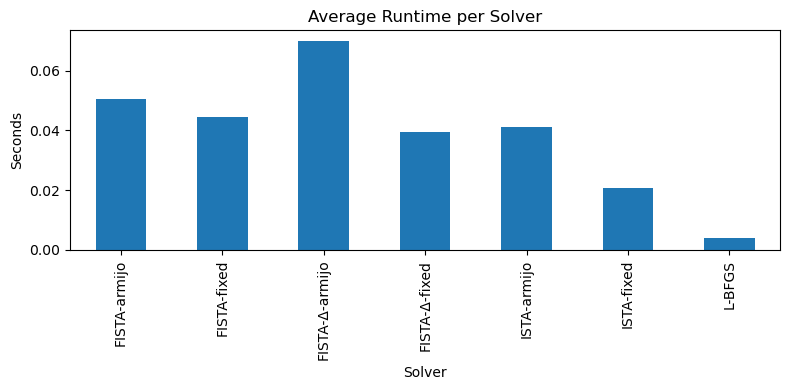

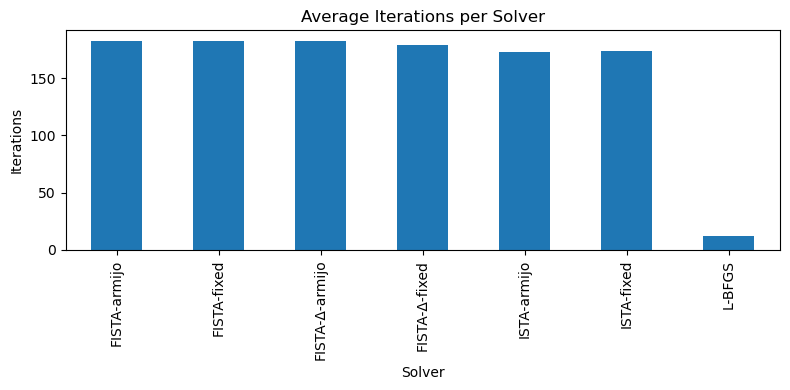

In [8]:
# --- Cell 8: Bar Plots ---
avg = df_metrics.groupby('solver')[['runtime_s','iterations']].mean()
plt.figure(figsize=(8,4))
avg['runtime_s'].plot.bar()
plt.title('Average Runtime per Solver')
plt.ylabel('Seconds'); plt.xlabel('Solver'); plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
avg['iterations'].plot.bar()
plt.title('Average Iterations per Solver')
plt.ylabel('Iterations'); plt.xlabel('Solver'); plt.tight_layout()
plt.show()

In [9]:
# --- Cell 9: Sub-routine Metrics Summary ---
cols = [
    'grad_num_calls','grad_time_total','grad_time_mean',
    'ls_num_calls','ls_time_total','ls_time_mean','ls_iters_total'
]
sub_summary = (
    df_metrics
      .groupby('solver')[cols]
      .agg(['mean','std'])
)
sub_summary.columns = [f"{m}_{s}" for m,s in sub_summary.columns]
sub_summary = sub_summary.reset_index()
print(sub_summary.to_markdown(index=False))

| solver         |   grad_num_calls_mean |   grad_num_calls_std |   grad_time_total_mean |   grad_time_total_std |   grad_time_mean_mean |   grad_time_mean_std |   ls_num_calls_mean |   ls_num_calls_std |   ls_time_total_mean |   ls_time_total_std |   ls_time_mean_mean |   ls_time_mean_std |   ls_iters_total_mean |   ls_iters_total_std |
|:---------------|----------------------:|---------------------:|-----------------------:|----------------------:|----------------------:|---------------------:|--------------------:|-------------------:|---------------------:|--------------------:|--------------------:|-------------------:|----------------------:|---------------------:|
| FISTA-armijo   |              182.635  |             30.3815  |            0.00756559  |           0.00451516  |           4.11716e-05 |          2.14716e-05 |             182.635 |            30.3815 |            0.0166091 |          0.00413886 |         9.08827e-05 |        1.599e-05   |               2.67708 |    